# MLP

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

In [2]:
# Normalise using MinMax scaler
from sklearn.preprocessing import MinMaxScaler

# Load CSV file into a pandas DataFrame
original = pd.read_csv('merged_data.csv')
print(original.shape)

# only select the specified columns
df = original.loc[:, ['Open','High','Low','Prev_Close','Volume','100SMA','20SMA','MNST','Retail Sales',
                      'Raw Sugar Futures','CPI','S&P500','GDP','Market Volatility','FTSE 100','SHEL','Gold',
                      'Close']].copy()

# df = original.loc[:, ['Prev_Close','Prev_Volume','100SMA','20SMA',
#                       'CPI','S&P500','GDP','Market Volatility','FTSE 100',
#                       'Close']].copy()
num_features = df.shape[1]-1

# Create an instance of MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the dataframe using fit_transform method of the scaler object
# and convert the resulting array back into a pandas datafram
data = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

data # scaled version of 'df'

(1970, 34)


,Open,High,Low,Prev_Close,Volume,100SMA,20SMA,MNST,Retail Sales,Raw Sugar Futures,CPI,S&P500,GDP,Market Volatility,FTSE 100,SHEL,Gold,Close
0,0.114228,0.103437,0.132088,0.115424,0.123980,0.004970,0.082477,0.012819,0.000000,0.470548,0.003250,0.024698,0.0,0.058936,0.621507,0.791707,0.186869,0.108897
1,0.114228,0.107817,0.136503,0.108897,0.136871,0.005225,0.083287,0.017963,0.000000,0.469178,0.003250,0.028351,0.0,0.050361,0.630381,0.801626,0.178475,0.113020
2,0.112892,0.098383,0.120883,0.113020,0.190338,0.005578,0.083158,0.020575,0.000000,0.447260,0.003250,0.028222,0.0,0.049680,0.618322,0.793333,0.174378,0.097561
3,0.096526,0.083558,0.110357,0.097561,0.170763,0.005927,0.082311,0.017199,0.000000,0.429452,0.003250,0.028433,0.0,0.049952,0.607407,0.797236,0.178375,0.090347
4,0.096860,0.093329,0.123260,0.090347,0.158732,0.006206,0.082090,0.026321,0.000000,0.435616,0.003250,0.029827,0.0,0.039744,0.624799,0.819187,0.195763,0.104088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1965,0.880427,0.878369,0.895756,0.917211,0.102860,0.892273,0.938138,0.961061,0.940883,0.800000,0.981106,0.680742,1.0,0.173540,0.885811,0.571057,0.735685,0.901408
1966,0.883100,0.887803,0.914431,0.901408,0.053462,0.892150,0.939446,0.966486,0.940883,0.806164,0.981106,0.688116,1.0,0.158568,0.887135,0.587967,0.744579,0.917898
1967,0.915164,0.914084,0.924278,0.931295,0.064196,0.892330,0.944309,0.967209,0.940883,0.750000,0.981106,0.667865,1.0,0.175854,0.895795,0.568130,0.756570,0.909310
1968,0.893120,0.897237,0.931409,0.909310,0.064349,0.892408,0.946317,0.975648,0.940883,0.758904,0.981106,0.689582,1.0,0.166326,0.901342,0.569919,0.768162,0.922364


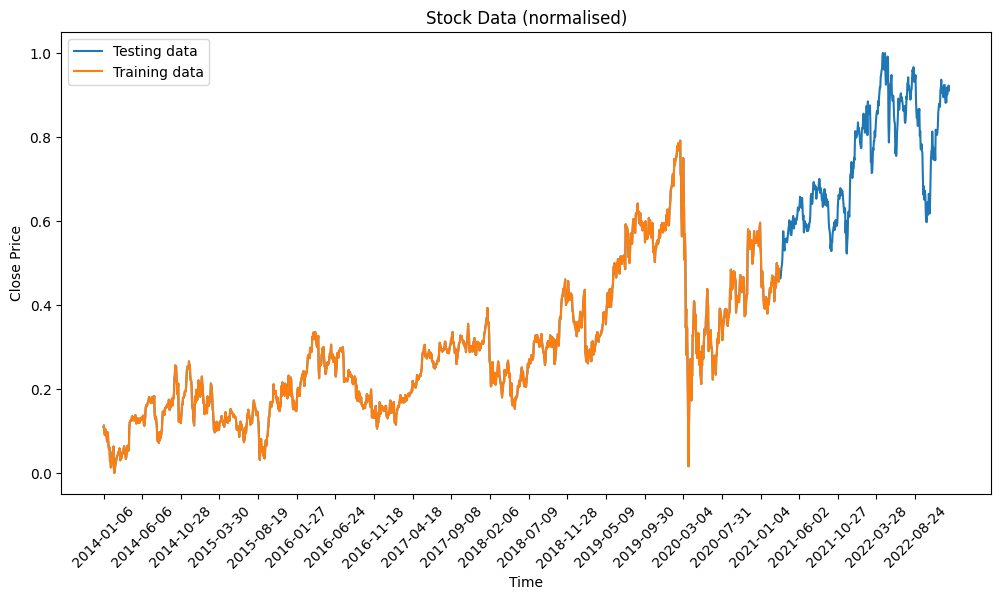

In [3]:
num_samples = len(data)

# Split the data into training and testing sets
train_data = data[:int(0.8 * num_samples)]
test_data_true = data[int(0.8 * num_samples):] # with label data

train_features = train_data.iloc[:, :-1] #x_train
test_data = test_data_true.iloc[:, :-1] 
test_features = test_data  # No label data x_test

test_data_true

num_train = train_data.shape[0]
df_plot = pd.DataFrame(data, columns=['Close'])

plt.figure(figsize = (12,6))
plt.plot(df_plot['Close'], label='Testing data')
plt.plot(df_plot['Close'][:num_train], label='Training data') 
plt.xticks(range(0, original.shape[0],3*30), original['Date'].loc[::3*30],rotation=45)

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Stock Data (normalised)')
plt.legend()

plt.show()

In [4]:
print(train_data.shape)
print(test_data.shape)

(1576, 18)
(394, 17)


In [5]:
all_features = pd.concat((train_data.iloc[:, :-1], test_data.iloc[:, :])) 

n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)

train_labels = torch.tensor(
    train_data.Close.values.reshape(-1, 1), dtype=torch.float32)

In [6]:
loss = nn.MSELoss()
in_features = train_features.shape[1] # number of columns, which stores the number of input features

print(in_features)

def get_net():
    # net = nn.Sequential(nn.Linear(in_features, 16), nn.ReLU(), nn.Linear(16, 1)) # not working!
    net = nn.Sequential(nn.Linear(in_features,1)) # creates a linear model with a single output (what 1 means)
                                                  # using the in_features number of input features.
    return net

17


In [7]:
def rmse(net, features, labels): 
    clipped_preds = net(features) # fitted
    rmse = torch.sqrt(loss(clipped_preds, labels))  # loss between fitted and true
    return rmse.item()

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []      # training and validation loss
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [8]:
def get_k_fold_data(k, i, X, y): # the ith fold as the validation dataset
    assert k > 1
    fold_size = X.shape[0] // k  # number of rows of X (integer-divided by) k
    X_train, y_train = None, None   # training dataset
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)  # slice(start, stop[, step]) returns a slice object 
                                                    # representing the indices specified by start, stop, and step
        X_part, y_part = X[idx, :], y[idx] # contains the subset of X and Y, that will be used as validation fold
        if j == i:
            X_valid, y_valid = X_part, y_part # X, Y of the validation fold
        elif X_train is None:
            X_train, y_train = X_part, y_part # if not the validation fold, they are used as training dataset
        else:
            X_train = torch.cat([X_train, X_part], 0) # 0 means axis=0, i.e. appending the rows of X_part to 
                                                      # the bottom of X_train
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid


# use the mean of the validation error to choose the best model
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, 
                                   weight_decay, batch_size) # *data here is to unpack the returned values 
                                                             # from get_k_fold_data()
        train_l_sum += train_ls[-1] # -1 means: only use the last element from the train_ls (training error list)
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     #legend=['train', 'valid'], yscale='log')
                     legend=['train', 'valid'])
        print(f'fold {i + 1}, train rmse {float(train_ls[-1]):f}, '
              f'valid rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train rmse 0.012640, valid rmse 0.006921
fold 2, train rmse 0.009689, valid rmse 0.007327
fold 3, train rmse 0.011179, valid rmse 0.014239
fold 4, train rmse 0.014105, valid rmse 0.016221
fold 5, train rmse 0.008644, valid rmse 0.017520
5-fold validation: avg train rmse: 0.011251, avg valid rmse: 0.012446


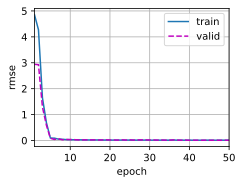

In [9]:
k, num_epochs, lr, weight_decay, batch_size = 5, 50, 5, 0, 64 # the numbers can change to find 
                                                               # the best combination of the hyperprameters
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train rmse: {float(train_l):f}, '
      f'avg valid rmse: {float(valid_l):f}')

train rmse 0.009353
Pred RMSE =   0.014237631605624855


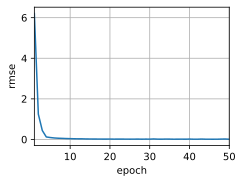

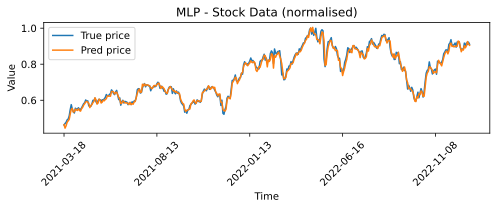

In [10]:
# once the best combination of hyperparameters have been found from k-fold cross validation, 
# apply it to the whole training dataset

def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='rmse', xlim=[1, num_epochs])
    print(f'train rmse {float(train_ls[-1]):f}')
    # Apply the network to the test set
    preds = net(test_features).detach().numpy() # if want to change to numpy data, need "detach" the gradient
    
    # add a new column named "Close" to the test_data DataFrame and assign the values of preds to it
    test_data['Close'] = pd.Series(preds.reshape(-1), index=test_data.index)
    
#     print(test_data_true.head())  
#     print(test_data.head()) 
    
    true_price = test_data_true['Close'].values
    pred_price = test_data['Close'].values
    
    rmse_pred = np.sqrt(np.mean((true_price - pred_price)**2))
    print('Pred RMSE =  ', rmse_pred)

    df = pd.DataFrame({'True price': true_price,'Pred price': pred_price})
    
    df.plot(figsize=(8, 2))    
    plot_x_test = original.tail(num_samples-train_data.shape[0])
    plt.xticks(range(0, plot_x_test.shape[0],3*30), plot_x_test['Date'].loc[::3*30],rotation=45)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title("MLP - Stock Data (normalised)")
    plt.legend()
    plt.show()

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)